<a href="https://colab.research.google.com/github/Savan-2003/AIML-2024/blob/main/Image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

# For checking score
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
INPUT_DIR = '/kaggle/input/flickr8k'
OUTPUT_DIR = '/kaggle/working'

In [ ]:
model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Printing the model summary
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tqdm import tqdm

# Initialize ResNet50 model for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Initialize an empty dictionary to store image features
image_features = {}

# Set the correct image directory (extracted folder)
img_dir = "/content/dataset"

# Iterate through images in the extracted dataset
for img_name in tqdm(os.listdir(img_dir), desc="Extracting Features"):
    img_path = os.path.join(img_dir, img_name)

    # Check if the path is a file (avoid directories)
    if not os.path.isfile(img_path):
        continue

    # Load the image
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    # Extract features using ResNet50
    image_feature = model.predict(image, verbose=0)
    image_id = os.path.splitext(img_name)[0]  # Remove extension

    # Store the feature in the dictionary
    image_features[image_id] = image_feature.flatten()  # Flatten for easy storage

print("Feature extraction completed!")


Extracting Features: 100%|██████████| 1/1 [00:00<00:00, 5242.88it/s]

Feature extraction completed!


In [ ]:
import os
import zipfile
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tqdm import tqdm

# Path to the ZIP file
zip_file = "/content/Image caption Generator dataset-20250224T105109Z-001.zip"
extract_dir = "/content/dataset"  # Folder where images will be extracted

# Extract the ZIP file
if not os.path.exists(extract_dir):  # Extract only if not already extracted
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Initialize ResNet50 model for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Initialize an empty dictionary to store image features
image_features = {}

# Get all image paths from the extracted directory
image_paths = [os.path.join(extract_dir, img) for img in os.listdir(extract_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Process each image
for img_path in tqdm(image_paths, desc="Extracting Features"):
    if not os.path.exists(img_path):
        print(f"Warning: File not found - {img_path}")
        continue  # Skip missing files

    # Load the image
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    # Extract features
    image_feature = model.predict(image, verbose=0)

    # Convert feature to 1D array for easier handling
    image_feature = image_feature.flatten()

    # Extract image ID from filename (without extension)
    image_id = os.path.splitext(os.path.basename(img_path))[0]

    # Store the extracted feature
    image_features[image_id] = image_feature

print("Feature extraction completed!")


Extracting Features: 0it [00:00, ?it/s]

Feature extraction completed!


In [ ]:
import os
import pickle

# Ensure the output directory exists before trying to write to it
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

In [ ]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

In [ ]:
with open(os.path.join(INPUT_DIR, '/content/Dataset_Link.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [ ]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

100%|██████████| 57/57 [00:00<00:00, 172742.29it/s]

Total number of captions: 9


In [ ]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

NameError: name 'image_to_captions_mapping' is not defined

In [ ]:
# preprocess the text
clean(image_to_captions_mapping)

In [ ]:
# after preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

[]

In [ ]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [ ]:
all_captions[:10]

['startseq specifically focusing on vehicle incidents each entry in the dataset includes various attributes that provide insights into the insured individuals their vehicles and the nature of the incidents they were involved in heres breakdown of the key components present in the dataset endseq',
 'startseq high school college phd endseq',
 'startseq spouse otherrelative endseq',
 'startseq  endseq',
 'startseq multivehicle collision vehicle theft endseq',
 'startseq front collision rear collision endseq',
 'startseq minor damage total loss endseq',
 'startseq honda ford endseq',
 'startseq this dataset is rich resource for analyzing insurance claims related to vehicle incidents providing insights into customer demographics policy details incident characteristics and claims processing it can be used for various analyses including risk assessment fraud detection and understanding the impact of demographics on insurance claims endseq']

In [ ]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [ ]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [ ]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 82
Maximum Caption Length: 48


In [ ]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    # Counter for the current batch size
    batch_count = 0

    while True:
        # Loop through each image in the current batch
        for image_id in data_keys:
            # Get the captions associated with the current image
            captions = image_to_captions_mapping[image_id]

            # Loop through each caption for the current image
            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Loop through the tokens in the caption sequence
                for i in range(1, len(caption_seq)):
                    # Split the sequence into input and output pairs
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad the input sequence to the specified maximum caption length
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]

                    # Convert the output sequence to one-hot encoded format
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append data to batch lists
                    X1_batch.append(features[image_id][0])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    # Increase the batch counter
                    batch_count += 1

                    # If the batch is complete, yield the batch and reset lists and counter
                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield [X1_batch, X2_batch], y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

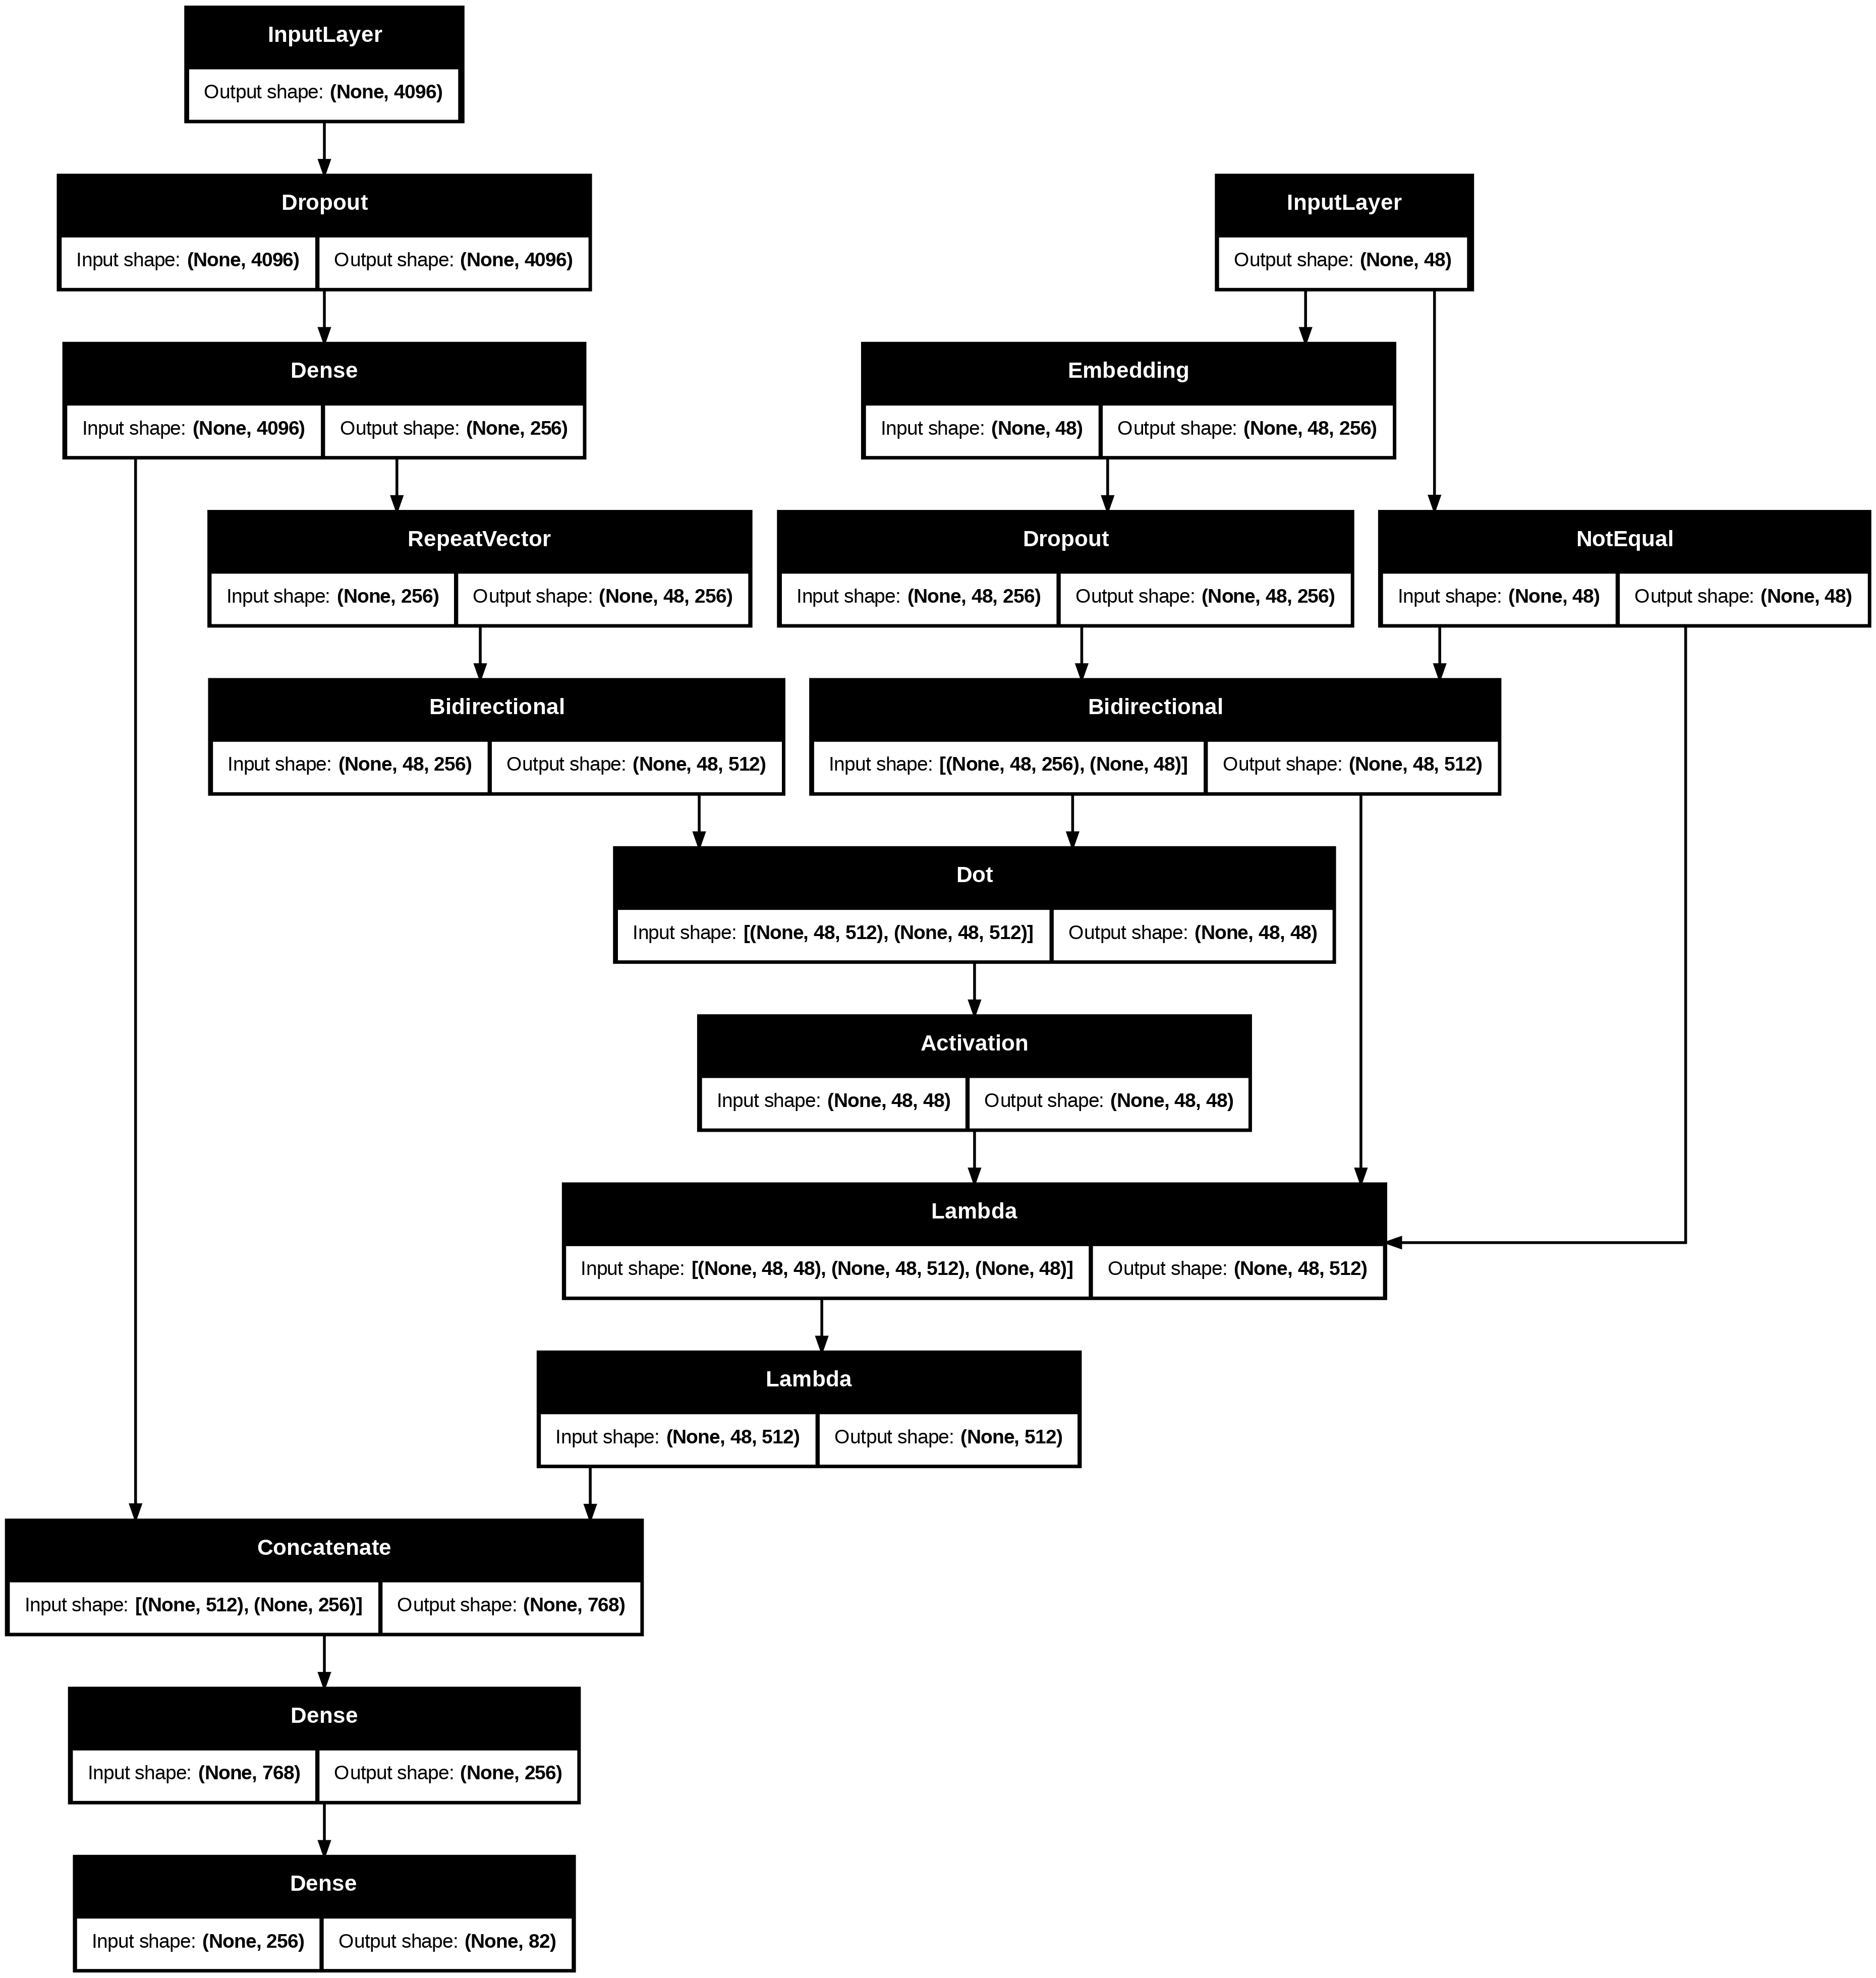

In [ ]:
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Apply attention scores to sequence embeddings
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

# Sum the attended sequence embeddings along the time axis
# Use Lambda layer to wrap tf.reduce_sum
context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention_context)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model
plot_model(model, show_shapes=True)

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    """
    Data generator for training image captioning models.

    Parameters:
    - data_keys: List of image IDs (keys).
    - image_to_captions_mapping: Dictionary mapping image IDs to lists of captions.
    - features: Dictionary mapping image IDs to their respective feature vectors.
    - tokenizer: Keras Tokenizer object for converting text to sequences.
    - max_caption_length: Maximum length of captions (for padding).
    - vocab_size: Size of the vocabulary (for one-hot encoding).
    - batch_size: Number of samples per batch.

    Yields:
    - A batch of data as a tuple: ((X1_batch, X2_batch), y_batch)
    """
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    batch_count = 0  # Counter for the current batch size

    while True:
        for image_id in data_keys:
            captions = image_to_captions_mapping[image_id]

            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(caption_seq)):
                    # Create input and output sequences
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad the input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]

                    # Convert the output sequence to one-hot encoded format
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append the data to batch lists
                    X1_batch.append(features[image_id])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    batch_count += 1

                    # If the batch is ready, yield it
                    if batch_count == batch_size:
                        # Convert lists to numpy arrays
                        X1_batch = np.array(X1_batch, dtype=np.float32)
                        X2_batch = np.array(X2_batch, dtype=np.int32)
                        y_batch = np.array(y_batch, dtype=np.float32)

                        yield ([X1_batch, X2_batch], y_batch)

                        # Reset the batch lists and counter
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0


In [ ]:
# Save the model
model.save(OUTPUT_DIR+'/mymodel.h5')

In [ ]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [ ]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'

    # Generate the caption
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)

        # Append the predicted word to the caption
        caption += " " + predicted_word

        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break

    return caption

In [ ]:
!pip install nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm

# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Check if the key exists in loaded_features
    if key in loaded_features:
        # Get actual captions for the current image
        actual_captions = image_to_captions_mapping[key]
        # Predict the caption for the image using the model
        predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)

        # Check if predicted caption is not empty and contains more than just 'startseq' and 'endseq'
        if predicted_caption and len(predicted_caption.split()) > 2:  # Check for meaningful content
            # Split actual captions into words
            actual_captions_words = [caption.split() for caption in actual_captions]
            # Split predicted caption into words
            predicted_caption_words = predicted_caption.split()

            # Append to the lists
            actual_captions_list.append(actual_captions_words)
            predicted_captions_list.append(predicted_caption_words)
        else:
            print(f"Warning: Empty or very short predicted caption for image ID '{key}'. Skipping.")

    else:
        print(f"Warning: Image ID '{key}' not found in loaded_features. Skipping.")

smoothie = SmoothingFunction().method4  # Choose a smoothing method (e.g., method4)

if predicted_captions_list:  # Check if predicted_captions_list is not empty
    print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0), smoothing_function=smoothie))
    print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))  # Apply smoothing to BLEU-2 as well
else:
    print("Warning: No valid predicted captions found for BLEU score calculation.")

100%|██████████| 1/1 [00:00<00:00, 8240.28it/s]

/content/1002674143_1b742ab4b8.jpg
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
/content/1002674143_1b742ab4b8.jpg
startseq aross aross aross aross aross aross aross aross aross aross aross aross aross aross aross aross aross aross aross brush brush brush brush aross brush aross brush brush aross brush aross brush brush aross


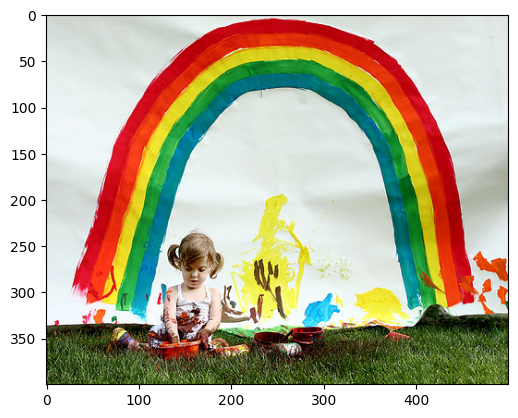

In [ ]:
generate_caption('/content/1002674143_1b742ab4b8.jpg')

/content/1032460886_4a598ed535.jpg
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
/content/1032460886_4a598ed535.jpg
startseq sets sets sets sets sets sets sets sets tikes tikes tikes tikes tikes mattress tikes mattress expanse mattress tikes mattress expanse tikes expanse mattress tikes expanse tikes expanse tikes expanse expanse tikes expanse tikes


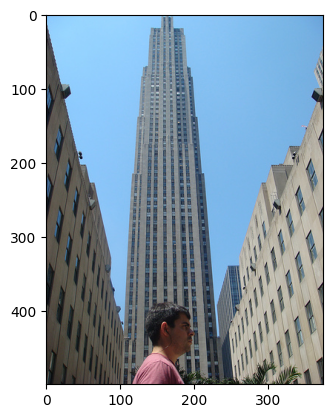

In [ ]:
generate_caption('/content/1032460886_4a598ed535.jpg')

/content/1032122270_ea6f0beedb.jpg
startseq woman crouches near three dogs in field endseq
startseq three dogs are playing on grassy hill with blue sky endseq
startseq three dogs are standing in the grass and person is sitting next to them endseq
startseq three dogs on grassy hill endseq
startseq three dogs stand in grassy field while person kneels nearby endseq
/content/1032122270_ea6f0beedb.jpg
startseq sets sets sets sets sets sets sets sets sets sets sets sets sets sets sets presents presents presents presents presents presents presents presents presents presents presents presents presents presents presents presents presents presents presents


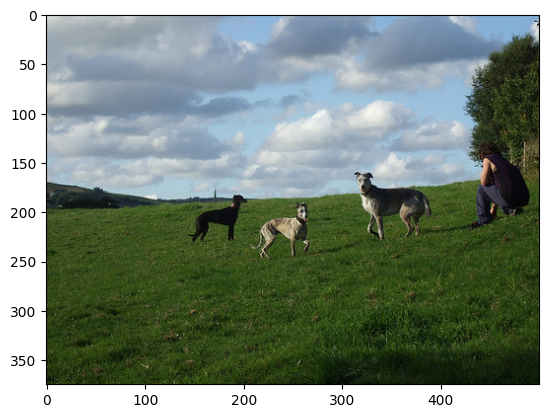

In [ ]:
generate_caption('/content/1032122270_ea6f0beedb.jpg')